In [1071]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [1072]:
class Regression:
    
    def __init__(self, feat_dims=0):
        # alpha is weight decay hyperparameter
        
        self.learning_rate = 0.000001
        self.epochs = 500
        self.batch_size = 100
        
        self.feat_dims = feat_dims
        self.output_classes = 1
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.01 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = 0.5  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std
        
        # calc feature-wise mean
        if mean is None:
            mean = np.mean(x, axis=0)
            
        # calc feature-wise std
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x_norm = x - mean

        # div by the standard dev.
        x_norm = x_norm / std

        return x_norm, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train
        
#         print('x before norm: ', x_train[0])
        
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], 1))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], 1))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector

        
        print('x after norm: ', x_train[:-1])
        
        
        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        temp = label - self.y_mean
        
        return temp

    def train_loss(self, x, yt_sm):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]        
        pred_y = np.dot(x, self.weights)
        residual = np.linalg.norm(pred_y - yt_sm, ord=2, axis=0) 
        sq_residual = np.square(residual)
        
        loss = (sq_residual / n_samples) + self.alpha * np.square( np.linalg.norm(self.weights, ord=2, axis=0) )
    
        return loss 
    
    def test_loss(self, x, yt_sm):
        # calc the cost at test time
        # yt = true label, is regular label
        
        n_samples = x.shape[0]  
        
        # need to add the mean back to label
        yt = yt_sm + self.y_mean
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # need to add the y mean back
        pred_y = pred_y + self.y_mean
        
        residual = np.linalg.norm(pred_y - yt, ord=2, axis=0) 
        sq_residual = np.square(residual)
        
        loss = (sq_residual / n_samples) + self.alpha * np.square( np.linalg.norm(self.weights, ord=2, axis=0) )
    
        return loss
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]
        
        pred_y = np.dot(x, self.weights)
        residual = pred_y - yt_sm
        dW = (np.dot(x.T, residual) / n_samples) + 2 * self.weights * self.alpha
        
        return dW

    def calc_mse(self, x, y_sm):
        # preprocesses and calls musicMSE
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # add the y mean to the pred
        pred_y += self.y_mean
        
        # add the y mean back to the labels
        y_labels = y_sm + self.y_mean
        
        # calc the MSE
        mse = self.musicMSE(pred_y, y_labels)
        
        print('MSE: ', mse)
        
        return mse, pred_y

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            
#             print('weights: ', self.weights)
            
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_sm):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        
        # calc loss
        loss = self.test_loss(x, y_sm)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_mse_arr = []
        test_mse_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Epoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            test_loss = self.test_phase(x_test, y_test_sm)
            
            train_mse, train_preds = self.calc_mse(x_train, y_train_sm)
            test_mse, test_preds = self.calc_mse(x_test, y_test_sm)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_mse_arr.append(train_mse)
            test_mse_arr.append(test_mse)
        
#         return train_losses, test_losses

        # return all the vals
        return train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds


    def plot_graph(self, train_losses, test_losses, train_mse, test_mse):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Epochs vs. Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (Cross entropy)")

        plt.subplot(1, 2, 2)
        plt.plot(train_mse, label="Train MSE")
        plt.plot(test_mse, label="Test MSE")
        plt.legend(loc='best')
        plt.title("Epochs vs MSE")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.show()

    def make_mesh_grid(self, x, y, h=0.02):
        # make a mesh grid for the decision boundary
        
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        x_x, y_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return x_x, y_y  # matrix of x-axis and y-axis

    def plot_contours(self, plt, x_x, y_y, **params):
        # plot contours    

        array = np.array([x_x.ravel(), y_y.ravel()])
        f = np.dot(array.T, self.weights)
        prob = self.softmax(f)
        Q = np.argmax(prob, axis=1) + 1
        Q = Q.reshape(x_x.shape)
        plt.contourf(x_x, y_y, Q, **params)  # takes in variable number of params

    def plot_decision_boundary(self, x, y):
        # plot decision boundary

        markers = ('o', '.', 'x')
        colors = ('yellow', 'grey', 'green')
        cmap = ListedColormap(colors[:len(np.unique(y))])
        x_x, y_y = self.make_mesh_grid(x, y)
        self.plot_contours(plt, x_x, y_y, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # plot training points
        for idx, cl in enumerate(np.unique(y)):
            xBasedOnLabel = x[np.where(y[:,0] == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
        plt.xlim(x_x.min(), x_x.max())
        plt.ylim(y_y.min(), y_y.max())
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Decision Boundary - Softmax Classifier")
        plt.legend(loc='upper left')
        plt.show()


In [1073]:
# create Regression() object to load data
regr = Regression()

In [1074]:
# # load the data
# fname = 'YearPredictionMSD.txt'
# x_train, y_train, x_test, y_test = regr.load_data(fname)

In [1075]:
# # discuss the properties of the data
# x_min = np.min(x_train)
# x_max = np.max(x_train)

# y_min = np.min(y_train)
# y_max = np.max(y_train)


# the range of the x feature values is huge, we from -14,000 to 65,000, with a wide
# range in scales too, from 1000s to decimals, so we'll need to normalize

# for the y labels, it's in years, from 1922-2011, and roughly the same in the test,
# though slightly wider range.

# The 90's and 2000's are much more over represented than the rest of the 
# years, expecially the earlier you get.

In [1076]:
# bins = np.linspace(1900, 2020, 20)

# plt.hist(y_train, bins, alpha=0.5, label='train')
# plt.hist(y_test, bins, alpha=0.5, label='test')
# plt.legend(loc='upper left')
# plt.show()

In [1077]:
# #  find the most common year (in test data)

# years_arr, count = np.unique(y_test, return_counts=True)
# year_count_dict = dict(zip(years_arr, count))
# # year_count_dict

In [1078]:
# # find the loss if every prediction is most commmon 
# n_samples = x_train.shape[0]
# most_common_year = 2007
# common_pred = np.full((n_samples, 1), most_common_year)

In [1079]:
# most_common_loss = regr.musicMSE(common_pred, y_train)
# most_common_loss
# #  most common year loss = 193.87

In [1080]:
# # find loss for 1998
# n_samples = x_train.shape[0]
# most_common_year = 1998
# common_pred = np.full((n_samples, 1), most_common_year)


In [1081]:
# loss_1998 = regr.musicMSE(common_pred, y_train)
# loss_1998
# #  1998 year loss = 119.82

In [1082]:
# ==========  Ridge Regression Training  =============

feat_dims = x_train.shape[1]

# create Regression() object to run training
regr = Regression(feat_dims)

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

# print('y train', y_train)
# print('y sub mean: ', y_train_sm)

# train_losses, test_losses = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)

train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Epoch 1 / 500...
MSE:  119.34317508615851
MSE:  117.42898437318377
Epoch 2 / 500...
MSE:  118.93488888839691
MSE:  117.02736999795816
Epoch 3 / 500...
MSE:  118.54262097218157
MSE:  116.6417108818896
Epoch 4 / 500...
MSE:  118.16588124825157
MSE:  116.27155682662298
Epoch 5 / 500...
MSE:  117.80359975907993
MSE:  115.91577675689689
Epoch 6 / 500...
MSE:  117.45496830401956
MSE:  115.57360732336842
Epoch 7 / 500...
MSE:  117.1193977090159
MSE:  115.24442312920509
Epoch 8 / 500...
MSE:  116.79608006942428
MSE:  114.9274318783144
Epoch 9 / 500...
MSE:  116.48437715050643
MSE:  114.62198913095955
Epoch 10 / 500...
MSE:  116.1837478532824
MSE:  114.32754973387206
Epoch 11 / 500...
MSE:  115.8934810269319
MSE:  114.04343076571024
Epoch 12 / 500...
MSE:  115.61325146276917
MSE:  113.76927062502484
Epoch 13 / 500...
MSE:  115.34250191655076
MSE:  113.50452081103603
Epoch 14 / 500...
MSE:  115.08071112789155
MSE:  113.24867873114064
Epoch 15 / 500...
MSE:  114.82745788590678
MSE:  113.001297417

MSE:  104.89161126055065
MSE:  103.40815464019703
Epoch 123 / 500...
MSE:  104.8565049816475
MSE:  103.3746565858608
Epoch 124 / 500...
MSE:  104.82182001524542
MSE:  103.34156799950934
Epoch 125 / 500...
MSE:  104.78751609533556
MSE:  103.30885910363939
Epoch 126 / 500...
MSE:  104.75363136088647
MSE:  103.27654744174832
Epoch 127 / 500...
MSE:  104.72008850027972
MSE:  103.24457449469357
Epoch 128 / 500...
MSE:  104.68695191165283
MSE:  103.21298693482996
Epoch 129 / 500...
MSE:  104.65424689911859
MSE:  103.18179724093424
Epoch 130 / 500...
MSE:  104.62187626038394
MSE:  103.15093985296998
Epoch 131 / 500...
MSE:  104.58988701889702
MSE:  103.12044435530474
Epoch 132 / 500...
MSE:  104.55830289487659
MSE:  103.09033996585573
Epoch 133 / 500...
MSE:  104.52708371400864
MSE:  103.06056261152622
Epoch 134 / 500...
MSE:  104.49620796223756
MSE:  103.03113676046844
Epoch 135 / 500...
MSE:  104.46573979749405
MSE:  103.00207965650974
Epoch 136 / 500...
MSE:  104.43552822872775
MSE:  102.9

MSE:  102.49627792314868
MSE:  101.13005491008315
Epoch 243 / 500...
MSE:  102.48565022852517
MSE:  101.11998689184047
Epoch 244 / 500...
MSE:  102.47510017876907
MSE:  101.10999352303153
Epoch 245 / 500...
MSE:  102.46460945098123
MSE:  101.10004311166281
Epoch 246 / 500...
MSE:  102.45424945436015
MSE:  101.09021200738418
Epoch 247 / 500...
MSE:  102.4439843940064
MSE:  101.08047083710429
Epoch 248 / 500...
MSE:  102.43380961595086
MSE:  101.07079140555878
Epoch 249 / 500...
MSE:  102.42371328498007
MSE:  101.06121657497094
Epoch 250 / 500...
MSE:  102.41371101868184
MSE:  101.05171345128727
Epoch 251 / 500...
MSE:  102.40378580052858
MSE:  101.04228658771818
Epoch 252 / 500...
MSE:  102.39395092818447
MSE:  101.0329580131304
Epoch 253 / 500...
MSE:  102.38418359284883
MSE:  101.02370217203459
Epoch 254 / 500...
MSE:  102.37452700039205
MSE:  101.01451908181456
Epoch 255 / 500...
MSE:  102.36491295251732
MSE:  101.00541040264412
Epoch 256 / 500...
MSE:  102.35542697513185
MSE:  100.9

MSE:  101.68118366713432
MSE:  100.35585757084333
Epoch 363 / 500...
MSE:  101.6771127125147
MSE:  100.3519708262328
Epoch 364 / 500...
MSE:  101.67305881788825
MSE:  100.34809655569195
Epoch 365 / 500...
MSE:  101.66902961011488
MSE:  100.34426042501784
Epoch 366 / 500...
MSE:  101.66504835462906
MSE:  100.3404714070129
Epoch 367 / 500...
MSE:  101.66108695883713
MSE:  100.33667545682306
Epoch 368 / 500...
MSE:  101.65713479322937
MSE:  100.3329481078116
Epoch 369 / 500...
MSE:  101.65322811388293
MSE:  100.32922550603111
Epoch 370 / 500...
MSE:  101.6493776114837
MSE:  100.3255517492238
Epoch 371 / 500...
MSE:  101.64553540756053
MSE:  100.3219105448856
Epoch 372 / 500...
MSE:  101.64169349308774
MSE:  100.31825869382386
Epoch 373 / 500...
MSE:  101.63788620725522
MSE:  100.31464059872988
Epoch 374 / 500...
MSE:  101.63410824435485
MSE:  100.31102859568182
Epoch 375 / 500...
MSE:  101.63037657398488
MSE:  100.307473002715
Epoch 376 / 500...
MSE:  101.6266857804533
MSE:  100.303935927

MSE:  101.35287961683152
MSE:  100.04263732612992
Epoch 483 / 500...
MSE:  101.35111850532222
MSE:  100.04097609511548
Epoch 484 / 500...
MSE:  101.34940492288881
MSE:  100.03933292439802
Epoch 485 / 500...
MSE:  101.34771035601155
MSE:  100.03770587270887
Epoch 486 / 500...
MSE:  101.34601540191818
MSE:  100.03607100658223
Epoch 487 / 500...
MSE:  101.34432052236228
MSE:  100.03444240940696
Epoch 488 / 500...
MSE:  101.34265274342484
MSE:  100.03284231383824
Epoch 489 / 500...
MSE:  101.34100427496202
MSE:  100.03126231708208
Epoch 490 / 500...
MSE:  101.33936786804229
MSE:  100.02969743807843
Epoch 491 / 500...
MSE:  101.33774396166973
MSE:  100.02814533108037
Epoch 492 / 500...
MSE:  101.33611157980167
MSE:  100.02658456399946
Epoch 493 / 500...
MSE:  101.33451354199623
MSE:  100.02502886081662
Epoch 494 / 500...
MSE:  101.33288114928023
MSE:  100.02348860533975
Epoch 495 / 500...
MSE:  101.33126278959422
MSE:  100.0219372058233
Epoch 496 / 500...
MSE:  101.32967162594741
MSE:  100.

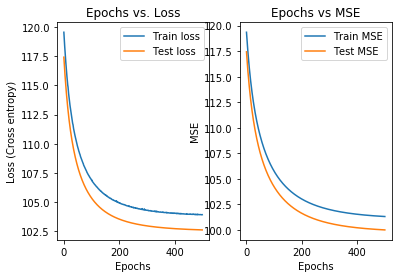

In [1083]:
# plot loss and accuracies graphs

regr.plot_graph(train_losses, test_losses, train_mse_arr, test_mse_arr)

In [1084]:
test_losses

[array([117.43052872]),
 array([117.03012386]),
 array([116.64655898]),
 array([116.27932138]),
 array([115.92722684]),
 array([115.58945944]),
 array([115.26534406]),
 array([114.95404471]),
 array([114.65487422]),
 array([114.36724699]),
 array([114.09044673]),
 array([113.82407177]),
 array([113.56754252]),
 array([113.32032737]),
 array([113.0819509]),
 array([112.85153259]),
 array([112.62964625]),
 array([112.41528233]),
 array([112.20822082]),
 array([112.00799495]),
 array([111.81438009]),
 array([111.62703091]),
 array([111.4456595]),
 array([111.27001172]),
 array([111.09978847]),
 array([110.93479546]),
 array([110.77478783]),
 array([110.61951144]),
 array([110.46884047]),
 array([110.32252434]),
 array([110.18042233]),
 array([110.04229123]),
 array([109.90798459]),
 array([109.77723463]),
 array([109.65018211]),
 array([109.52653923]),
 array([109.40618158]),
 array([109.28893988]),
 array([109.17472404]),
 array([109.06338766]),
 array([108.95489201]),
 array([108.849061

In [1085]:
train_losses

[119.57203129891172,
 119.12500078271091,
 118.75886251543695,
 118.35372268946183,
 117.97664271871605,
 117.6403081353713,
 117.29300991069775,
 116.99367326805285,
 116.65999000534399,
 116.35264739277765,
 116.08710298089476,
 115.7904831809204,
 115.52689141857252,
 115.26761092402074,
 115.01658739010736,
 114.88060148552938,
 114.56277778482449,
 114.32523034490309,
 114.10393546851525,
 113.91727563182732,
 113.69547859887177,
 113.5127559658481,
 113.30704845189074,
 113.13718651415685,
 112.9503153404554,
 112.7895778834855,
 112.61714471502573,
 112.44594425331132,
 112.30509584916335,
 112.13125355011306,
 111.98977599778847,
 111.84576243087477,
 111.70560137314644,
 111.63107402610586,
 111.44659082739653,
 111.29549988471027,
 111.1702445743615,
 111.0737614171717,
 110.93329644691336,
 110.82910387366512,
 110.70634832299004,
 110.60027602352764,
 110.47748921373773,
 110.38568315900748,
 110.29545648405802,
 110.17417138376823,
 110.10457307839872,
 109.97807578768217,

In [1086]:
test_preds


array([[1995.872123  ],
       [1997.19983614],
       [1999.63206785],
       ...,
       [1998.02924628],
       [2000.83595304],
       [1999.2587014 ]])

In [1087]:
test_preds[20000:20030]

array([[1996.02831122],
       [1999.04196295],
       [1995.80358183],
       [2000.1001921 ],
       [1999.71191376],
       [2000.66470503],
       [2002.0131659 ],
       [1997.69706783],
       [1999.30145829],
       [1999.56504634],
       [1998.86733276],
       [2000.24154795],
       [1998.5376578 ],
       [1998.25622415],
       [1997.7662212 ],
       [1997.51352359],
       [2000.22618712],
       [1995.7762065 ],
       [1996.7139734 ],
       [1998.15008037],
       [1999.07783621],
       [1998.53276157],
       [1999.2047416 ],
       [1998.16775918],
       [1999.57673278],
       [1999.07039447],
       [1996.14511399],
       [1997.92342566],
       [1999.30205886],
       [1996.73902961]])